# Import Libraries

In [8]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
import pandas as pd 
from tabulate import tabulate
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [19]:
train1 = pd.read_csv('train_month_3_with_target.csv')
train2 = pd.read_csv('train_month_2.csv')
train3 = pd.read_csv('train_month_1.csv')
test1 = pd.read_csv('test_month_3.csv')
test2 = pd.read_csv('test_month_2.csv')
test3 = pd.read_csv('test_month_1.csv')

## Dataset type info

In [10]:
#train1.info()
train1.describe()
train1.isna().any()
train1.dtypes

client_id                             object
homebanking_active                     int64
has_homebanking                        int64
has_insurance_21                       int64
has_insurance_23                       int64
has_life_insurance_fixed_cap           int64
has_life_insurance_decreasing_cap      int64
has_fire_car_other_insurance           int64
has_personal_loan                      int64
has_mortgage_loan                      int64
has_current_account                    int64
has_pension_saving                     int64
has_savings_account                    int64
has_savings_account_starter            int64
has_current_account_starter            int64
bal_insurance_21                       int64
bal_insurance_23                       int64
cap_life_insurance_fixed_cap           int64
cap_life_insurance_decreasing_cap      int64
prem_fire_car_other_insurance          int64
bal_personal_loan                      int64
bal_mortgage_loan                      int64
bal_curren

In [11]:
train1['customer_since_all'] = pd.to_datetime(train1['customer_since_all'])
train1['customer_since_bank'] = pd.to_datetime(train1['customer_since_bank'])
train1['customer_birth_date'] = pd.to_datetime(train1['customer_birth_date'])

cat_vars = []
cont_vars = []
columns = list(train1.drop(columns = ['client_id']).columns)
for i in columns:
    if (len(train1.loc[:,i].unique()) >= 20):
        cont_vars.append(i)
    else:
        cat_vars.append(i)
        
print('Continious variables are:',cont_vars)
print('------------------')
print('Categorical variables are:',cat_vars)
# Here we have our list of categorical and continious variables

Continious variables are: ['bal_insurance_21', 'bal_insurance_23', 'cap_life_insurance_fixed_cap', 'cap_life_insurance_decreasing_cap', 'prem_fire_car_other_insurance', 'bal_personal_loan', 'bal_mortgage_loan', 'bal_current_account', 'bal_pension_saving', 'bal_savings_account', 'bal_savings_account_starter', 'bal_current_account_starter', 'customer_since_all', 'customer_since_bank', 'customer_birth_date', 'customer_postal_code']
------------------
Categorical variables are: ['homebanking_active', 'has_homebanking', 'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap', 'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance', 'has_personal_loan', 'has_mortgage_loan', 'has_current_account', 'has_pension_saving', 'has_savings_account', 'has_savings_account_starter', 'has_current_account_starter', 'visits_distinct_so', 'visits_distinct_so_areas', 'customer_gender', 'customer_occupation_code', 'customer_self_employed', 'customer_education', 'customer_children', 

### Categorical features unique values

In [12]:
# To check we will print all unique values
for col in cat_vars:
    print(col,train1[col].unique())

homebanking_active [0 1]
has_homebanking [0 1]
has_insurance_21 [0 1]
has_insurance_23 [0 1]
has_life_insurance_fixed_cap [0 1]
has_life_insurance_decreasing_cap [0 1]
has_fire_car_other_insurance [1 0]
has_personal_loan [0 1]
has_mortgage_loan [0 1]
has_current_account [1 0]
has_pension_saving [0 1]
has_savings_account [1 0]
has_savings_account_starter [0 1]
has_current_account_starter [0 1]
visits_distinct_so [1. 2. 3. 4. 6. 5. 7.]
visits_distinct_so_areas [1. 2. 3. 5. 4. 6.]
customer_gender [1 2]
customer_occupation_code [ 9. nan  7.  8.  4.  5.  0.  6.  3.  1.  2.]
customer_self_employed [0 1]
customer_education [ 0. nan  2.  1.  4.  3.  5.  6.]
customer_children [nan 'mature' 'no' 'young' 'preschool' 'adolescent' 'grownup' 'onebaby'
 'yes']
customer_relationship [nan 'couple' 'single']
target [0 1]


### Colums with missing Data

In [13]:
missing_df = train1.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/train1.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
29,customer_since_all,234,0.367364
30,customer_since_bank,249,0.390913
34,customer_occupation_code,2002,3.143005
38,customer_relationship,14899,23.390427
37,customer_children,23364,36.679906
36,customer_education,47125,73.983076


# Data pre-processing

In [38]:
train1 = pd.read_csv('train_month_3_with_target.csv')
train2 = pd.read_csv('train_month_2.csv')
train3 = pd.read_csv('train_month_1.csv')
test1 = pd.read_csv('test_month_3.csv')
test2 = pd.read_csv('test_month_2.csv')
test3 = pd.read_csv('test_month_1.csv')

In [39]:
df_list=[train1,train2,train3,test1,test2,test3]

## Remove columns and transform date columns

In [40]:
def drop_col(x):
    x.drop(['customer_children','customer_relationship','customer_occupation_code','customer_education',],axis=1, inplace=True) 
    x.dropna(axis=0, inplace=True) 

In [41]:
def striptime(x):
    x['customer_since_all'] = pd.to_datetime(x['customer_since_all'])
    x['customer_since_bank'] = pd.to_datetime(x['customer_since_bank'])
    x['customer_birth_date'] = pd.to_datetime(x['customer_birth_date'])
    x['Birth_year'] = x['customer_birth_date'].dt.strftime('%Y').astype(str).astype(int)
    x['Year_since_all'] = x['customer_since_all'].dt.strftime('%Y').astype(str).astype(int)
    x['Month_since_all'] = x['customer_since_all'].dt.strftime('%m').astype(str).astype(int)
    x['Year_since_bank'] = x['customer_since_bank'].dt.strftime('%Y').astype(str).astype(int)
    x['Month_since_bank'] = x['customer_since_bank'].dt.strftime('%m').astype(str).astype(int)
    x.drop(['customer_since_all','customer_since_bank','customer_birth_date'], axis=1, inplace=True)



In [42]:
for x in df_list:
    drop_col(x)
    striptime(x)
    print(x.shape)




(63448, 38)
(63448, 37)
(63448, 37)
(27183, 37)
(27183, 37)
(27183, 37)


## Removing outliers

We have noticed some of the clients are born in the 80s. Therefore we will assign a threshhold of 100years for the client's age.  In addition, the client's birth year cannot greater than the year he started using the banks services.

In [30]:
def remove_out(x):
    x.drop(x[x['Birth_year'] < 1919].index, inplace = True)
    x.drop(x.loc[x['Birth_year'] > (x['Year_since_all'] | x['Year_since_bank'])].index, inplace=True)

remove_out(train1)
remove_out(train2)
remove_out(train3)
remove_out(test1)
remove_out(test2)
remove_out(test3)

# EDA

## Feature Engineering

First, let's extract the customer's Age and drop Birth_year

In [ ]:
def client_age(x):
    x['Age'] = x['Birth_year'].apply(lambda x: 2018 -x)
    x.drop('Birth_year', axis=1, inplace=True)
    
for x in df_list:
    client_age(x)

- We could see if there is a significant (large) difference in say balance or savings as this could be an indicator that the client is about to churn. (can just be stored as a boolean). 
- can also compute a boolean regarding the change in some services that the client has. Say he dropped in insurrance 21 last month or smtg. also as a boolean 

In [48]:
#creates a new column in the dataset with a boolean regarding if the values between the 3 columns are the same. 

def bool_change(orig1,orig2,orig3, cols,key ='client_id'):
    columns= [key] + cols 
    merged = pd.merge(orig1,orig2[columns], how = 'left',on = key, suffixes=['','-1'])
    merged = pd.merge(merged,orig3[columns], how = 'left',on = key, suffixes=['','-2'])
    to_drop =[]
    for var in cols:
        merged['ch_{}'.format(var)] = np.where((merged[var]==merged['{}-1'.format(var)])&(
                                   merged[var] == merged['{}-2'.format(var)]),0,1)
        to_drop+=['{}-1'.format(var),'{}-2'.format(var)]
    merged.drop(to_drop,axis=1,inplace=True)
    return merged

In [77]:
# create a new column regarding if there was a change in any var that starts w has_... in the last couple months
# will be 1 if there was any change in the last 2 months 0 otherwise
to_bool = ['homebanking_active', 'has_homebanking',
       'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap',
       'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance',
       'has_personal_loan', 'has_mortgage_loan', 'has_current_account',
       'has_pension_saving', 'has_savings_account',
       'has_savings_account_starter', 'has_current_account_starter']
train_s = bool_change(train1,train2,train3, to_bool)
train_s.columns

Index(['client_id', 'homebanking_active', 'has_homebanking',
       'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap',
       'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance',
       'has_personal_loan', 'has_mortgage_loan', 'has_current_account',
       'has_pension_saving', 'has_savings_account',
       'has_savings_account_starter', 'has_current_account_starter',
       'bal_insurance_21', 'bal_insurance_23', 'cap_life_insurance_fixed_cap',
       'cap_life_insurance_decreasing_cap', 'prem_fire_car_other_insurance',
       'bal_personal_loan', 'bal_mortgage_loan', 'bal_current_account',
       'bal_pension_saving', 'bal_savings_account',
       'bal_savings_account_starter', 'bal_current_account_starter',
       'visits_distinct_so', 'visits_distinct_so_areas', 'customer_gender',
       'customer_postal_code', 'customer_self_employed', 'customer_children',
       'target', 'Year_since_all', 'Month_since_all', 'Year_since_bank',
       'Month_s

In [78]:
#check if df is factorable 
train_fa = train_s.drop(['client_id','target'],axis=1)
chi_square_value,p_value=calculate_bartlett_sphericity(train_fa)
chi_square_value, p_value

(1903852.9837954768, 0.0)

In [79]:
_,kmo_model=calculate_kmo(train_fa)

In [81]:
fa = FactorAnalyzer(n_factors=30,rotation=None )
fa.fit(train_fa )
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\factor_analyzer\factor_analyzer.py:563: UserWarning: Failed to converge: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  warnings.warn('Failed to converge: {}'.format(res.message))


array([1.27624860e+01, 5.26828970e+00, 2.47056173e+00, 1.98521350e+00,
       1.91758109e+00, 1.87439969e+00, 1.76122832e+00, 1.73822059e+00,
       1.69806838e+00, 1.59247717e+00, 1.55156603e+00, 1.47787651e+00,
       1.33006153e+00, 1.26031811e+00, 1.11508500e+00, 1.08160810e+00,
       1.00619025e+00, 9.45175419e-01, 8.23765855e-01, 7.90107704e-01,
       5.39777629e-01, 5.19627255e-01, 4.94228656e-01, 4.49059884e-01,
       4.17091671e-01, 4.05668433e-01, 4.02265873e-01, 3.36250441e-01,
       3.02810721e-01, 2.63540132e-01, 2.60718615e-01, 2.47677058e-01,
       2.41224672e-01, 1.97328222e-01, 1.63412501e-01, 1.55326083e-01,
       1.47538494e-01, 1.44890148e-01, 1.36332797e-01, 1.30903937e-01,
       1.17440005e-01, 1.06329586e-01, 1.01083717e-01, 8.48032611e-02,
       6.46858430e-02, 4.99703220e-02, 3.55985027e-02, 1.58042213e-02,
       9.56490211e-03, 5.50340286e-03, 3.26237132e-03])

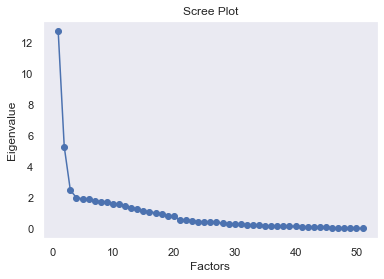

In [82]:
# Create scree plot
plt.scatter(range(1,train_fa.shape[1]+1),ev)
plt.plot(range(1,train_fa.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [83]:
 #Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(20, rotation="varimax")
fa.fit(train_fa)

FactorAnalyzer(n_factors=20, rotation='varimax', rotation_kwargs={})

In [84]:
pd.DataFrame(fa.loadings_, index=train_fa.columns)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
homebanking_active,0.052526,0.214735,0.751740,0.014646,0.063219,0.054548,0.000579,0.059403,0.023097,0.094615,0.055761,0.073724,0.094417,0.052162,0.008725,0.112690,0.167332,0.160702,0.000319,-0.022200
has_homebanking,0.054015,0.185765,0.930865,0.011367,0.057307,0.049959,0.023749,0.051106,0.023426,0.080185,0.056871,0.117292,0.105861,0.050551,0.009954,0.057589,0.182545,0.105320,0.015304,0.019005
has_insurance_21,0.004274,0.052155,0.060038,0.030104,0.985569,0.015795,-0.014618,0.040642,0.010933,0.031260,0.015134,0.008057,0.009107,0.057197,0.010670,0.015694,0.072362,0.014769,0.006714,-0.009667
has_insurance_23,0.002015,0.002636,0.014025,0.992203,0.038059,0.001853,-0.014907,0.007397,0.000043,-0.000079,0.025104,0.011886,0.002219,0.012610,0.014339,0.000550,0.009982,0.001621,0.012652,-0.000252
has_life_insurance_fixed_cap,-0.004390,0.008307,0.001142,0.002875,0.010133,-0.000327,-0.010378,0.019419,0.003987,0.007635,-0.005567,-0.001826,0.008108,0.030386,0.756299,-0.002958,0.012998,0.010043,0.007362,0.014416
has_life_insurance_decreasing_cap,-0.007209,0.792167,0.194517,0.002291,0.060011,0.011360,0.022871,0.092921,0.015955,0.073642,0.022635,0.027602,0.083746,0.114703,0.017793,0.204903,0.214401,0.075075,-0.035722,0.244713
has_fire_car_other_insurance,0.001315,0.056461,0.038807,0.000476,0.035454,0.035888,-0.064933,0.937475,0.005805,0.022680,0.002012,-0.000701,0.023788,0.076787,0.012287,0.040931,-0.014489,0.014106,0.069823,-0.009592
has_personal_loan,-0.001271,0.056821,0.077026,-0.005203,0.033897,0.017258,-0.010210,0.079341,0.002449,0.930204,0.006088,-0.004119,0.040116,0.057320,0.001804,0.055064,0.064815,0.043623,0.039240,0.014068
has_mortgage_loan,0.011298,0.446555,0.175608,0.002912,0.040231,0.019092,0.006272,0.113560,0.014573,0.114141,0.021637,0.023889,0.089120,0.133177,0.018809,0.811656,0.153241,0.092532,0.054345,0.126161
has_current_account,0.040929,0.120645,0.386230,0.015581,0.060967,0.033674,-0.085751,0.096368,0.038545,0.097036,0.042282,0.074364,0.261702,0.049467,0.009230,0.095184,0.077242,0.749171,0.042293,-0.011078


In [85]:
# check variance explained 
pd.DataFrame(fa.get_factor_variance(), index=['SS Loadings','Proportion Var','Cumulative Var'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
SS Loadings,12.646471,2.242863,1.867747,1.779569,1.771656,1.725732,1.690656,1.674438,1.554405,1.533855,1.531190,1.345497,1.340089,1.201985,1.194413,1.142796,0.948378,0.748686,0.359582,0.211635
Proportion Var,0.247970,0.043978,0.036622,0.034894,0.034738,0.033838,0.033150,0.032832,0.030479,0.030076,0.030023,0.026382,0.026276,0.023568,0.023420,0.022408,0.018596,0.014680,0.007051,0.004150
Cumulative Var,0.247970,0.291948,0.328570,0.363464,0.398202,0.432040,0.465190,0.498022,0.528501,0.558576,0.588600,0.614982,0.641258,0.664827,0.688246,0.710654,0.729250,0.743930,0.750981,0.755130


# Modeling Selection

# Model Evaluation

# Model Improvement